In [1]:
print("Hello World!")

Hello World!


### 1. Select an LLM

In [2]:
import os
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model

load_dotenv()
api_key = os.getenv('GEMINI_API_KEY')

model = init_chat_model("google_genai:gemini-3-flash-preview", temperature=1, api_key=api_key)


### 2. Chunking Data

In [3]:
import json
from pathlib import Path
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 1) Load paragraph-style KB JSON
KB_JSON_PATH = "kb_paragraphs.json"  # update path if needed
items = json.loads(Path(KB_JSON_PATH).read_text(encoding="utf-8"))

all_docs = []

for item in items:
    # 2) Each record already contains a paragraph in "text"
    paragraph = (item.get("text") or "").strip()
    if not paragraph:
        continue

    # 3) Build the Document with metadata
    doc = Document(
        page_content=paragraph,
        metadata={
            "id": item.get("id"),
            "title": item.get("title"),
            "category": item.get("category"),
            "source_file": item.get("source_file"),
            "paragraph_index": item.get("paragraph_index"),
            "doc_type": "paragraph"
        }
    )
    all_docs.append(doc)

print(f"Total paragraph docs: {len(all_docs)}")
print("Sample metadata:", all_docs[0].metadata)
print("Sample content:\n", all_docs[0].page_content[:300])


Total paragraph docs: 31
Sample metadata: {'id': '01_company_overview_p01', 'title': 'Company Overview', 'category': 'company', 'source_file': '01_company_overview.md', 'paragraph_index': 1, 'doc_type': 'paragraph'}
Sample content:
 COB Solution supports medical providers and healthcare practices by helping reduce administrative burden and improve day-to-day workflows. The goal is to help practices stay focused on patient care while still running efficient operations and sustaining growth.


### 3. Embedding

In [4]:
import os
from dotenv import load_dotenv
from langchain_google_genai import GoogleGenerativeAIEmbeddings

load_dotenv()
api_key = os.getenv('GEMINI_API_KEY')

embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001", api_key=api_key)

In [5]:
# Test
vector_1 = embeddings.embed_query(all_docs[0].page_content)
vector_2 = embeddings.embed_query(all_docs[1].page_content)

assert len(vector_1) == len(vector_2)
print(f"Generated vectors of length {len(vector_1)}\n")
print(vector_1[:10])

Generated vectors of length 3072

[-0.007270903, -0.01333494, 0.012871559, -0.10176539, -0.03965242, -0.008132168, 2.7634205e-05, 0.0027858196, 0.019066531, -0.010399304]


### 4. Vector stores

In [6]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

retriever = vector_store.as_retriever()

In [17]:
ids = vector_store.add_documents(documents=all_docs)

In [ ]:
# Test
embedding = embeddings.embed_query("what is COB?")

results = vector_store.similarity_search_by_vector(embedding)
print(results)

[Document(id='99fa581a-9e25-49ce-9cd0-05e75609127b', metadata={'doc_type': 'paragraph', 'category': 'company', 'source_file': '01_company_overview.md', 'paragraph_index': 3, 'title': 'Company Overview', 'id': '01_company_overview_p03'}, page_content='COB Solution is headquartered in New York, NY. For general inquiries, you can contact the team through the following channels. \nEmail: info@cobsolution.com  \nPhone: (929) 229-7207'), Document(id='c92928e9-2be7-471e-9eb5-1b58a906bdaf', metadata={'category': 'company', 'paragraph_index': 1, 'doc_type': 'paragraph', 'title': 'Company Overview', 'id': '01_company_overview_p01', 'source_file': '01_company_overview.md'}, page_content='COB Solution supports medical providers and healthcare practices by helping reduce administrative burden and improve day-to-day workflows. The goal is to help practices stay focused on patient care while still running efficient operations and sustaining growth.'), Document(id='971da8f6-637d-485c-8c82-8b9e2c94d4b8

##### 4.2. Create a retriever tool using the @tool decorator:

In [20]:
from langchain.tools import tool

@tool
def retrieve_blog_posts(query: str) -> str:
    """Search and return information about COB Solution campony."""
    docs = retriever.invoke(query)
    return "\n\n".join([doc.page_content for doc in docs])


retriever_tool = retrieve_blog_posts

In [22]:
# Test 
queries = [
    "Where is COB Solution headquartered?",
    "What are the booking rules for rescheduling and cancellation?",
    "What does RCM mean and why is it important?",
    "Can you help reduce no-shows?",
    "When should the chatbot escalate to a human agent?"
]

retriever_tool.invoke({"query": queries[1]})

'Booking rules for the demo are simple: rescheduling and cancellations are allowed up to 24 hours before the appointment time, and if a caller is more than 10 minutes late, the appointment may be shortened or rescheduled. Before confirming a booking, the chatbot should summarize the selected service and time and ask the user to confirm.\n\nAppointment support focuses on keeping schedules organized and making the booking experience simple for patients. Typical support includes scheduling, confirmations, follow-ups, and rescheduling requests, using the practice’s rules for hours, services, and required information.\n\nThis booking catalog is designed for the hiring-task demo so the chatbot can schedule multiple types of appointments. Each service has a duration and a clear purpose. The chatbot should collect a name, a contact method, the service type, and a preferred date/time window before offering available slots.\n\nService C: Patient Engagement & No-Show Reduction Plan (30 minutes). 

---------

In [23]:
from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model

response_model = init_chat_model("google_genai:gemini-3-flash-preview", temperature=0, api_key=api_key)


def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        response_model
        .bind_tools([retriever_tool]).invoke(state["messages"])  
    )
    return {"messages": [response]}

In [24]:
# Test the tool
input = {"messages": [{"role": "user", "content": "hello!"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'type': 'text', 'text': "Hello! How can I help you today? If you're looking for information about COB Solution, I can certainly assist with that!", 'extras': {'signature': 'EoAECv0DAXLI2nx8asRYOI3a7MKf6wLh6kAAQqW1MoOR0WBc8EAeNADGHnBMbIdgtt6fPoGsHQ9O2DQ/v+KHKhM+Yf2Bib6+2O26QaeahUUBkzFL2HcbrCaQAij8FS18nbZiEjEume2sIFmOTZBdTGXWAwdgVauv0eJVyRnv8O6qUVP0PybMs/RgZ/vutGaiJbwZNGFk/qd1n0GO6h9g/WoHsi/uIdfdZlj3Q1ifmJLMi/719GbBisR57kOVsKzrNxSLu2ntuuQ+6xqOyrB+Hq3K3uAKyCjo5NTUUO5EL9FTG4PsbXjst3MrnxNsTFRNeGfplUgdUzN48toEKqD3VLlMscbJ0Wq1vpKfgGyU9uKtvD4lueBN7uH99dm4wQirnQdOTOZtm7DIuvXx6AKHaB/RXEQdICUCt0LGLtowgu7XeO5fSUDFmJk2Hik53Rcn7hcA/CD9Lwg9eROeQxR/leNREguEUrN9mkq0iaHPG8WVB2FMQFj0oEPb5TWGx+ig2NMx+ZWo0pHegAMH89XBtwZglt9VL3Pb/1RKqu1qrW1bXlxdbScI5Wu+P5m8VCbUNxWbkbbNe2AXJc0WtTQGBEx3gKyear0YAUAcVJ9av8WVij1LMqVtHjiKLSYX1avpI65gFpE/CrFU5/S6vxfE1cGQJUu8WS+ibfuMzIFcj7qOGew='}}]


In [25]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "Can you help reduce no-shows?",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

[]
Tool Calls:
  retrieve_blog_posts (bb1650f0-dcd4-4c51-b648-11eca1e72dc7)
 Call ID: bb1650f0-dcd4-4c51-b648-11eca1e72dc7
  Args:
    query: reduce no-shows appointment reminders scheduling system


In [26]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


class GradeDocuments(BaseModel):  
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )


grader_model = init_chat_model("google_genai:gemini-3-flash-preview", temperature=0, api_key=api_key)


def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(  
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

In [28]:
# test grade_documents function
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "Can you help reduce no-shows?"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite_question'

In [29]:
from langchain.messages import HumanMessage

REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [HumanMessage(content=response.content)]}

In [30]:
# test grade_documents function
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "Can you help reduce no-shows?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)
print(response["messages"][-1].content)

[{'type': 'text', 'text': 'To provide the most helpful response, the initial question needs more context regarding the **industry**, the **current process**, and the **specific goals**.\n\nHere are three ways to formulate an improved question, depending on what you need:\n\n### Option 1: For Strategic Advice (General Business)\n> "What are the most effective psychological and operational strategies for reducing appointment no-shows in a [Insert Industry, e.g., medical clinic/consulting firm]? Please include best practices for reminder schedules and cancellation policies."\n\n### Option 2: For Implementation (Content & Tools)\n> "Can you provide a series of automated SMS and email reminder templates designed to minimize no-shows? Also, recommend 3–5 software tools that specialize in automated appointment confirmations and waitlist management."\n\n### Option 3: For Problem-Solving (Data-Driven)\n> "I currently have a [Insert %] no-show rate in my [Insert Industry]. My current process is 

In [31]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [32]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

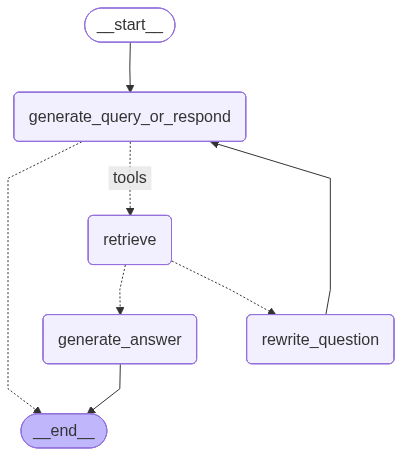

In [33]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "whats me name?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================

[{'type': 'text', 'text': "I'm sorry, I don't know your name. Since I don't have access to your personal information or identity, you'll have to tell me what it is!", 'extras': {'signature': 'EoUHCoIHAXLI2nzoFBinJbToHt3/HsAW6wajFdoEhVY9wVvDWrj8svXJPM27n1lpBB6wBWcYQImuQL3dNTwsmnzjV/H9SsUeUokuGSP3P+ALLPoWT/CvPgWFfd8b7ChmOpSRbA8EMp+k9c70HeuFD3lYfrb26cYMYTR/mn0BlFBVFTVWl87B1EkddclXubKCyqQkDb/bKSB30DwKJb02mBQm2yc9quaaYH0tVWgK4B2gKZLy5iyED5EHxESjmKsp6jHNNLHtMcn91uJQsc+mJkJiB5AxBut7UeZTZ1jHDcIR+JI6E5wbjsAthdhkQBHEGudvyA2YXKqEx65waTVxMNlR4cmDpsCSzjXMmNqN69tHWPuAKus45DnV90fFHgv5j06tGdyhg+kNrAILrVqitwhjyacHkSp0FNHq3AiVCfJDW0J+tB8d1KKbv7UI2jffu98w5/3pWvK7wSKeKYvaJKowsATCpMEVovUQNvTQdq8ulL+Z6ZfCUHZ9n6wPXt0mInWH8RClfNoakHF8dUzwjAGjMkeOIVQjk1pCWwkQTsnSsBp9y7bYVbo+WH95p0JNtPLHRAbFT/u7XaPfL0715iAHIXHceKZyP5308JwrYcZzNn+kmG3j6Yw5R58+wdeS7KYP53hO6vcbTIlVZsPhH7hOM/kzlDW2vMTF9nHn9Gi

### Agentic RAG

In [ ]:
import bs4
from langchain.agents import AgentState, create_agent
from langchain_community.document_loaders import WebBaseLoader
from langchain.messages import MessageLikeRepresentation
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Construct a tool for retrieving context
@tool(response_format="content_and_artifact")
def retrieve_context(query: str):
    """Retrieve information to help answer a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

tools = [retrieve_context]
# If desired, specify custom instructions
prompt = (
    "You have access to a tool that retrieves context from a blog post. "
    "Use the tool to help answer user queries."
)
agent = create_agent(model, tools, system_prompt=prompt)